In [18]:
import numpy as np
from main import *
from utils import Utility
from Fair_Taxi_MDP_Penalty_V2 import Fair_Taxi_MDP_Penalty_V2


In [19]:
size = 10
# loc_coords = [[0,0],[3,2]]
# dest_coords = [[0,4],[3,3]]
loc_coords = [[0,2],[9,7]]
dest_coords = [[0,0],[9,9]]
fuel = 40

env = Fair_Taxi_MDP_Penalty_V2(
    size=size,
    loc_coords=loc_coords,
    dest_coords=dest_coords,
    fuel=fuel,
    output_path=None
)

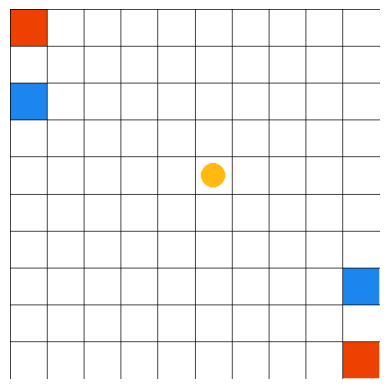

In [20]:
# 환경 생성
env = Fair_Taxi_MDP_Penalty_V2(
    size=size,
    loc_coords=loc_coords,
    dest_coords=dest_coords,
    fuel=fuel,
    output_path=None
)

# 초기 상태를 (5,4)로 세팅
state = env.reset(taxi_loc=[5,4])

# 렌더링
frame = env.render(mode="rgb_array")  # numpy array로 프레임 얻기

import matplotlib.pyplot as plt
plt.imshow(frame)
plt.axis("off")
plt.show()


In [21]:
dataset = np.load("./data/bus.npy", allow_pickle=True).item()
dataset

{'states': array([326, 386, 326, ..., 596, 590, 584], dtype=int32),
 'actions': array([2, 3, 1, ..., 1, 1, 4], dtype=int32),
 'rewards': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]], dtype=float32),
 'next_states': array([386, 326, 320, ..., 590, 584, 586], dtype=int32),
 'dones': array([False, False, False, ..., False, False,  True]),
 'timesteps': array([ 0,  1,  2, ..., 37, 38, 39], dtype=int32),
 'Raccs': array([[  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        ...,
        [  0., 150.],
        [  0., 150.],
        [  0., 150.]], dtype=float32),
 'initial_states': array([326, 326, 326, ..., 326, 326, 326], dtype=int32)}

In [22]:
dataset['states']

array([326, 386, 326, ..., 596, 590, 584], dtype=int32)

In [23]:
for k,v in dataset.items():
    print(k, np.array(v).shape)

states (96000,)
actions (96000,)
rewards (96000, 2)
next_states (96000,)
dones (96000,)
timesteps (96000,)
Raccs (96000, 2)
initial_states (96000,)


In [25]:
env.action_space.n

6

In [26]:
env.observation_space.n

600

In [27]:
import numpy as np

def build_from_offline_data(dataset, S, A, H, I, eps=1e-8):
    states = dataset["states"]
    actions = dataset["actions"]
    rewards = dataset["rewards"]
    next_states = dataset["next_states"]
    timesteps = dataset["timesteps"]
    initial_states = dataset["initial_states"]

    # 1. Initial distribution p0
    p0 = np.bincount(initial_states, minlength=S).astype(np.float64)
    p0 /= p0.sum()

    # 2. Transition probability T_base[s', s, a]
    T_base = np.zeros((S, S, A), dtype=np.float64)
    for s, a, s_next in zip(states, actions, next_states):
        T_base[s_next, s, a] += 1
    T_base += eps
    T_base /= T_base.sum(axis=0, keepdims=True)

    # 3. Dataset occupancy d_D[s, a, t]
    d_D = np.zeros((S, A, H), dtype=np.float64)
    for s, a, t in zip(states, actions, timesteps):
        d_D[s, a, t] += 1
    # normalize each timestep distribution
    for t in range(H):
        total_t = d_D[:, :, t].sum()
        if total_t > 0:
            d_D[:, :, t] /= total_t
    d_D = np.clip(d_D, eps, None)

    # 4. Reward vectors r_i(s,a)
    r_list = []
    for i in range(I):
        r_i = np.zeros((S, A), dtype=np.float64)
        counts = np.zeros((S, A), dtype=np.float64)
        for s, a, r in zip(states, actions, rewards[:, i]):
            r_i[s, a] += r
            counts[s, a] += 1
        with np.errstate(divide='ignore', invalid='ignore'):
            r_i = np.divide(r_i, counts, out=np.zeros_like(r_i), where=counts > 0)
        r_list.append(r_i)

    return p0, T_base, d_D, r_list


In [29]:
dataset = np.load("./data/bus.npy", allow_pickle=True).item()
S = env.observation_space.n       # 600
A = env.action_space.n            # 6
H = 40
I = 2

p0, T_base, d_D, r_list = build_from_offline_data(dataset, S, A, H, I)

# result = solve_cp(
#     p0, T_base, d_D, r_list,
#     alpha=0.1, reg_type="chi2", util_type="piecewise_lower"
# )
# print(result["z_values"], result["piecewise_util_post"])


In [45]:
env.reset(taxi_loc = [5,4])

np.int64(326)

In [37]:
T_base.shape

(600, 600, 6)

In [42]:
d_D.shape

(600, 6, 40)

In [40]:
r_list

[array([[  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0., -10., -10.],
        ...,
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0., -10.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.]]),
 array([[  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0., -10., -10.],
        ...,
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0., -10.,  30.],
        [  0.,   0.,   0.,   0.,   0.,   0.]])]

In [43]:
p0

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [5]:
# ---- Load dataset ----
dataset = np.load("./data/bus.npy", allow_pickle=True).item()

# ---- Preprocess timesteps ----
dataset = preprocess_timesteps(dataset)

# ---- Preprocess rewards ----
dataset, norm_stats = preprocess_rewards(dataset, method='linear')

# ---- Preprocess Raccs ----
dataset = preprocess_Raccs(dataset, horizon=fuel)

dataset = preprocess_states(dataset, env, one_hot_pass_idx=True, concat_raccs=True)

# ---- Preprocess scalarization ----
utility = Utility(kind='piecewise_log', weights=None, shift=0.0)
dataset = preprocess_scalarization(dataset, utility)
dataset['rewards'] = dataset['scalarized_rewards']

In [6]:
dataset

{'states': array([[5., 4., 0., ..., 1., 0., 0.],
        [6., 4., 0., ..., 1., 0., 0.],
        [5., 4., 0., ..., 1., 0., 0.],
        ...,
        [9., 9., 0., ..., 1., 0., 5.],
        [9., 8., 0., ..., 1., 0., 5.],
        [9., 7., 0., ..., 1., 0., 5.]]),
 'actions': array([2, 3, 1, ..., 1, 1, 4], dtype=int32),
 'rewards': array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 'next_states': array([[6., 4., 0., ..., 1., 0., 0.],
        [5., 4., 0., ..., 1., 0., 0.],
        [5., 3., 0., ..., 1., 0., 0.],
        ...,
        [9., 8., 0., ..., 1., 0., 5.],
        [9., 7., 0., ..., 1., 0., 5.],
        [9., 7., 1., ..., 0., 0., 5.]]),
 'dones': array([False, False, False, ..., False, False,  True]),
 'timesteps': array([ 0,  1,  2, ..., 37, 38, 39], dtype=int32),
 'Raccs': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 5.],
        [0., 5.],
        [0., 5.]], dtype=float32),
 'initial_states'

In [7]:
for k, v in dataset.items():
    print(k, v.shape)

states (96000, 8)
actions (96000,)
rewards (96000, 1)
next_states (96000, 8)
dones (96000,)
timesteps (96000,)
Raccs (96000, 2)
initial_states (96000, 8)
next_timesteps (96000,)
next_Raccs (96000, 2)
scalarized_rewards (96000, 1)


In [8]:
dataset['states'][:41]

array([[ 5.        ,  4.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ],
       [ 6.        ,  4.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ],
       [ 5.        ,  4.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ],
       [ 5.        ,  3.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ],
       [ 4.        ,  3.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ],
       [ 3.        ,  3.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ],
       [ 2.        ,  3.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ],
       [ 1.        ,  3.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ],
       [ 0.        ,  3.        

In [9]:
dataset['rewards'].shape

(96000, 1)

In [10]:
def to_episode_arrays_fixed_horizon(dataset, horizon=100):
    num_steps = dataset['states'].shape[0]
    num_episodes = num_steps // horizon
    print("num_episodes:", num_episodes)

    def reshape(arr, extra_dims=None):
        if extra_dims is None:
            arr = arr.reshape(num_episodes, horizon)
        else:
            arr = arr.reshape(num_episodes, horizon, *extra_dims)
        return arr

    out = {
        'states': reshape(dataset['states'], (dataset['states'].shape[1],)),        # (1000, 100, 8)
        'actions': reshape(dataset['actions']),                                    # (1000, 100)
        'rewards': reshape(dataset['rewards'], (1,)),                              # (1000, 100, 1)
        'next_states': reshape(dataset['next_states'], (dataset['next_states'].shape[1],)),  # (1000, 100, 8)
        'dones': reshape(dataset['dones']),                                        # (1000, 100)
        'timesteps': reshape(dataset['timesteps']),                                # (1000, 100)
        'Raccs': reshape(dataset['Raccs'], (dataset['Raccs'].shape[1],)),          # (1000, 100, 2)
        'initial_states': reshape(dataset['initial_states'], (dataset['initial_states'].shape[1],)),  # (1000, 100, 8)
        'next_timesteps': reshape(dataset['next_timesteps']),                      # (1000, 100)
        'next_Raccs': reshape(dataset['next_Raccs'], (dataset['next_Raccs'].shape[1],)),  # (1000, 100, 2)
    }

    return out

episodes_data = to_episode_arrays_fixed_horizon(dataset, horizon=40)

for k, v in episodes_data.items():
    print(k, v.shape)


num_episodes: 2400
states (2400, 40, 8)
actions (2400, 40)
rewards (2400, 40, 1)
next_states (2400, 40, 8)
dones (2400, 40)
timesteps (2400, 40)
Raccs (2400, 40, 2)
initial_states (2400, 40, 8)
next_timesteps (2400, 40)
next_Raccs (2400, 40, 2)


In [11]:
import numpy as np

# 에피소드별 reward 합계 구하기
episode_rewards = episodes_data['rewards'].sum(axis=(1, 2))  # (num_episodes,)

# 보상이 가장 큰 episode index
best_ep_idx = np.argmax(episode_rewards)
print("Best episode index:", best_ep_idx)
print("Total reward:", episode_rewards[best_ep_idx])

# 해당 episode의 Raccs
best_ep_Raccs = episodes_data['Raccs'][best_ep_idx]  # (horizon, 2)
print("Raccs shape:", best_ep_Raccs.shape)
print(best_ep_Raccs)


Best episode index: 596
Total reward: 3.6931486
Raccs shape: (40, 2)
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]


In [12]:
import numpy as np

# 마지막 타임스텝의 Raccs (num_episodes, 2)
last_Raccs = episodes_data['Raccs'][:, -1, :]

# 여기서 기준을 어떻게 정할지? (예: 첫 번째 축, 두 번째 축, 혹은 합계)
# 보통 합계 기준으로 많이 씀
last_Raccs_sum = last_Raccs.sum(axis=1)

# 가장 큰 episode 찾기
best_ep_idx = np.argmax(last_Raccs_sum)
print("Best episode index (by final Raccs sum):", best_ep_idx)
print("Final Raccs:", last_Raccs[best_ep_idx])

# 그 에피소드의 전체 Raccs trajectory 확인
best_ep_Raccs = episodes_data['Raccs'][best_ep_idx]
print("Best episode Raccs shape:", best_ep_Raccs.shape)
print(best_ep_Raccs)


Best episode index (by final Raccs sum): 2
Final Raccs: [5. 0.]
Best episode Raccs shape: (40, 2)
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [2. 0.]
 [3. 0.]
 [3. 0.]
 [3. 0.]
 [3. 0.]
 [3. 0.]
 [3. 0.]
 [4. 0.]
 [4. 0.]
 [4. 0.]
 [4. 0.]
 [4. 0.]
 [4. 0.]
 [5. 0.]
 [5. 0.]
 [5. 0.]]


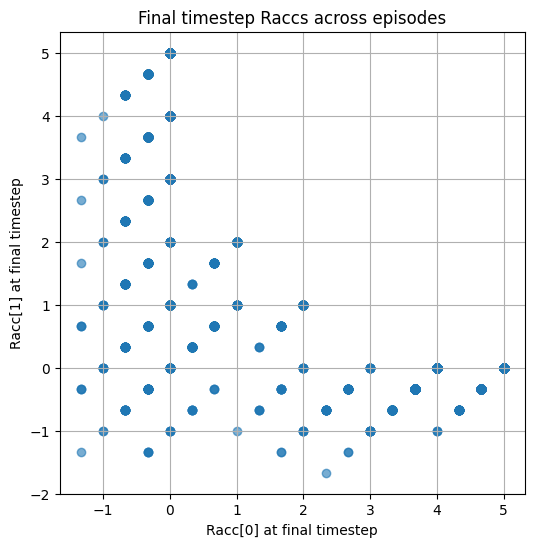

In [13]:
import matplotlib.pyplot as plt

# 마지막 타임스텝의 Raccs (num_episodes, 2)
last_Raccs = episodes_data['Raccs'][:, -1, :]

# 산점도 플롯
plt.figure(figsize=(6,6))
plt.scatter(last_Raccs[:,0], last_Raccs[:,1], alpha=0.6)
plt.xlabel("Racc[0] at final timestep")
plt.ylabel("Racc[1] at final timestep")
plt.title("Final timestep Raccs across episodes")
plt.grid(True)
plt.show()


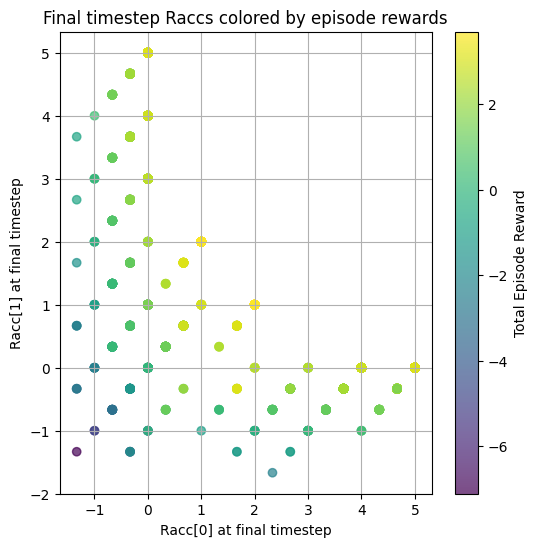

In [14]:
# 에피소드별 reward 합계
episode_rewards = episodes_data['rewards'].sum(axis=(1, 2))

plt.figure(figsize=(6,6))
sc = plt.scatter(
    last_Raccs[:,0], last_Raccs[:,1],
    c=episode_rewards, cmap='viridis', alpha=0.7
)
plt.xlabel("Racc[0] at final timestep")
plt.ylabel("Racc[1] at final timestep")
plt.title("Final timestep Raccs colored by episode rewards")
plt.colorbar(sc, label="Total Episode Reward")
plt.grid(True)
plt.show()


In [15]:
dataset['rewards'].min(), dataset['rewards'].max(), dataset['rewards'].mean(), dataset['rewards'].std()

(np.float32(-2.1111126),
 np.float32(2.8333337),
 np.float32(0.055052184),
 np.float32(0.33470663))